- import labeled data set
-- use all data, then take care about multiple similar looking images
- split into train / test sets
- train classifier
- test classifier

------------
ideas:
- train convnet on HOG features 
- train convnet on hog_image (?) -> does this make sense? 

In [1]:
import numpy as np 
import glob
import cv2

def read_images(image_dir_list):    
    images = []
    
    for img_dir in image_dir_list:    
    
        # get all image files in the current directory
        img_file_list = glob.glob('./training_data/' + img_dir + '/?*.png')

        for img_file in img_file_list:
            img = cv2.imread(img_file)        
            images.append(img)
            #images.append(np.ravel(img))
    
    print('imported {} images'.format(len(images)))  
            
    return images         

In [88]:
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def get_hog_feature_map(img):
    pix_per_cell = 8
    cell_per_block = 2
    num_orientations = 9     

    features = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                   cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                   visualise=False, feature_vector=False)
    
#     if plot_result:
#         fig = plt.figure()
#         plt.subplot(121)
#         plt.imshow(img, cmap='gray')
#         plt.title('Example Car Image')
#         plt.subplot(122)
#         plt.imshow(hog_image, cmap='gray')
#         plt.title('HOG Visualization')
#         plt.show()
    
    return features

def get_hog_feature_vec(img):
    pix_per_cell = 8
    cell_per_block = 2
    num_orientations = 9     

    feature_vec = hog(img, orientations=num_orientations, pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), block_norm='L2-Hys',
                      visualise=False, feature_vector=True)

    return feature_vec

def plot_feature_vec(feature_vec):
    plt.bar(np.arange(0, len(feature_vec)), feature_vec)
    plt.show()
    
def normalize_vec(feature_vec):
    # Reshape the vector
    vector = feature_vec.reshape(-1, 1)
    # Create the scaler for normalization
    scaler = StandardScaler().fit(vector)
    # Apply the scaler 
    scaled_vec = scaler.transform(vector)
    
    return scaled_vec
        
def convert_to_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def extract_features(images):
    features = []
    
    for img in images:
        img = convert_to_gray(img)
        feature_vec = get_hog_feature_vec(img)
        features.append(normalize_vec(feature_vec))
        
    return features



In [3]:
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
import pickle

def calculate_test_accuracy(classifier, features, labels):   
    
    pred = classifier.predict(features)
    num_correct = np.count_nonzero(pred == labels)
    acc = 1.0*num_correct/len(labels)
            
    return acc
            

def create_classifier(vehicle_features, non_vehicle_features):

    # create input data 'X' from features
    X = np.vstack((vehicle_features, non_vehicle_features))
    X = X.reshape((X.shape[0], X.shape[1]))

    # create output labels 'y': 1=vehicle, 0=non-vehicle
    vehicle_labels = np.ones((len(vehicle_features)))
    non_vehicle_labels = np.zeros((len(non_vehicle_features)))
    y = np.hstack((vehicle_labels, non_vehicle_labels))

    # shuffle the data
    X, y = shuffle(X, y)

    # split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # train a SVM for classification by performing a grid search in parameter space
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 3, 5, 7, 9]}
    svc = svm.SVC()
    classifier = GridSearchCV(svc, parameters)
    classifier.fit(X_train, y_train)  

    print('finished training')
    print('best parameters: {}'.format(classifier.best_params_)) # {'C': 5, 'kernel': 'rbf'}
    
    acc = calculate_test_accuracy(classifier, X_test, y_test)
    print('test accuracy: {:.3f}'.format(acc))
    
    # save the classifier
    with open('classifier.pkl', 'wb') as fid:
        pickle.dump(classifier, fid)  
        print('saved classifier')
    
    return classifier


C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tobias\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [6]:
train_classifier = False

if train_classifier: # train a new classifier 

    # read vehicle images
    vehicle_images = read_images(['vehicles/GTI_Far', 'vehicles/GTI_Left', 'vehicles/GTI_MiddleClose', 
                    'vehicles/GTI_Right']) #, 'vehicles/KITTI_extracted'])
    
    # read non-vehicle images
    non_vehicle_images = read_images(['non-vehicles/GTI']) #, 'non-vehicles/Extras'])

    # extract features from images
    vehicle_features = extract_features(vehicle_images)  
    non_vehicle_features = extract_features(non_vehicle_images)  
    
    # train the classifier
    classifier = create_classifier(vehicle_features, non_vehicle_features)  
    
else: # open a saved classifier
    
    with open('classifier.pkl', 'rb') as fid:
        classifier = pickle.load(fid)   
        print('loaded classifier')


loaded classifier


In [98]:
# pix_per_cell = 8 
# small image: 64 x 64 
# full image shape: (720, 1280, 3) 


# 64x64 image patches
# factor 1.5: 96x96 image patches
# factor 2: 128x128 image patches
# ...
# factor 4: 256x256 image patches


def get_divisible_range(max_value, crop_percentage, divider):
    
    start = int(max_value*crop_percentage[0])
    end = int(max_value*crop_percentage[1])
    
    delta = end - start     
    delta = delta - (delta % divider)
    
    end = start + delta
    
    return start, end
    

def crop_image(img): #crop the image in a way that the height and width is divisible by 'pix_per_cell'
    
    y_crop_percentage = [0.5, 1.0]
    x_crop_percentage = [0.0, 1.0]
    
    pix_per_cell = 8
    
    y_start, y_end = get_divisible_range(img.shape[0], y_crop_percentage, pix_per_cell)
    x_start, x_end = get_divisible_range(img.shape[1], x_crop_percentage, pix_per_cell)
    
    img_cropped = img[y_start:y_end, x_start:x_end]
    
    return img_cropped

def draw_patches(img_input, patches):
    
    img = np.copy(img_input)
    
    for patch in patches:
        img = cv2.rectangle(img, (patch[0], patch[1]), (patch[2], patch[3]), (0,255,0), 2)
        
    return img
 

def get_patches(img):
    
    pix_per_cell = 8 # same as for training the classifier
    cells_per_patch = 8 # same number as for training the classifier
    
    stride_x = 8 # stride of 4 = 50% overlap
    stride_y = 8 # stride of 4 = 50% overlap
    
    start_x = 0
    start_y = 0
    
    end_x = img.shape[1]
    end_y = img.shape[0]
    
    img_patches = []
    hog_patches = []   

    px = start_x
    py = start_y       

    qx = px + pix_per_cell*cells_per_patch 
    qy = py + pix_per_cell*cells_per_patch 

    while qx < end_x:           

        while qy < end_y:

            img_patches.append((px, py, qx, qy)) 
            hog_patches.append((int(px/cells_per_patch), 
                                int(py/cells_per_patch), 
                                int(qx/cells_per_patch), 
                                int(qy/cells_per_patch)))

            py += stride_y*pix_per_cell                
            qy = py + pix_per_cell*cells_per_patch 

        px += stride_x*pix_per_cell
        qx = px + pix_per_cell*cells_per_patch   

        py = start_y   
        qy = py + pix_per_cell*cells_per_patch 
            
    return img_patches, hog_patches   
   

def get_sliding_window_features(img_orig, ):
    
    size_levels = [1, 2, 3, 4, 5]
    
    for size_level in size_levels:
        img = cv2.resize(img_orig, None, fx=1.0/size_level, fy=1.0/size_level)
        hog_map = get_hog_feature_map(convert_to_gray(img))
        
        img_patches, hog_patches = get_patches()
        
        #for patch     
        
        
        # create resized image
        # create hog map for resized image
        
    
    
    
    
    return 

def get_patches(img):    
    pix_per_cell_orig = 8 # same as for training the classifier
    cells_per_patch = 8 # same number as for training the classifier
    
    stride_x = 8 # stride of 4 = 50% overlap
    stride_y = 8 # stride of 4 = 50% overlap
    size_levels = [1,2,3,4,5]
    
    start_x = 0
    start_y = 0
    
    end_x = img.shape[1]
    end_y = img.shape[0]
    
    img_patches = []
    hog_patches = []
    
    for level in size_levels:    
        
        img_patches_level = []
        
        img_patches.append(img_patches_level)
        
        
        pix_per_cell = level*pix_per_cell_orig
        
        px = start_x
        py = start_y       
    
        qx = px + pix_per_cell*cells_per_patch 
        qy = py + pix_per_cell*cells_per_patch 
    
        while qx < end_x:           
            
            while qy < end_y:
                
                img_patches.append((px, py, qx, qy)) 
                hog_patches.append((int(px/cells_per_patch), 
                                    int(py/cells_per_patch), 
                                    int(qx/cells_per_patch), 
                                    int(qy/cells_per_patch)))
 
                py += stride_y*pix_per_cell                
                qy = py + pix_per_cell*cells_per_patch 
                
            px += stride_x*pix_per_cell
            qx = px + pix_per_cell*cells_per_patch   
            
            py = start_y   
            qy = py + pix_per_cell*cells_per_patch 
            
    return img_patches, hog_patches           
            

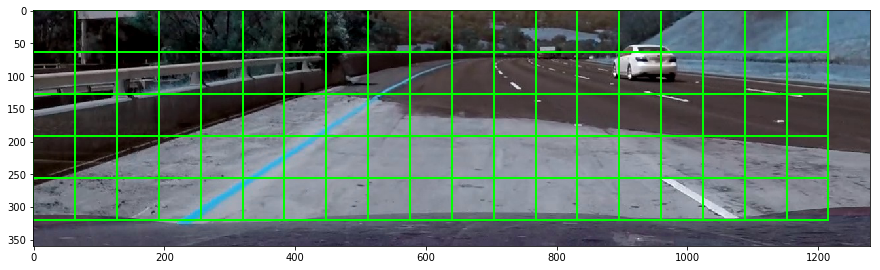

(44, 159, 2, 2, 9)


In [100]:
def classify_patches(img, img_patches, hog_feature_map, hog_patches):
    
    for hog_patch in hog_patches:
        pred = classifier.predict(hog_feature_map[hog_patch[0]:hog_patch[1],
                                                 hog_patch[2]:hog_patch[3]])
        if pred == 1
        





# TEST
img = cv2.imread('./test_image.jpg')
img = crop_image(img)

img_patches, hog_patches = get_patches(img)
img = draw_patches(img, img_patches)


plt.figure(figsize=(15,10))
plt.imshow(img)
plt.show()

img = convert_to_gray(img)
feature_map = get_hog_feature_map(img)

print(feature_map.shape)
